In [1]:
import sys
import os
sys.path.append("../src/")
import combat
import numpy as np
import scipy.stats as stats
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import sklearn
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sb
import pickle as pkl
from sklearn.linear_model import LogisticRegression, Lasso, Ridge, ElasticNet
import random as rd
import matplotlib
matplotlib.rcParams['figure.dpi'] = 500
from sklearn.preprocessing import quantile_transform,binarize
from sklearn.model_selection import LeaveOneOut,KFold
from sklearn.metrics import r2_score
from statsmodels.stats.multitest import multipletests
from sklearn.cross_decomposition import PLSRegression as PLS
import warnings
warnings.simplefilter("ignore")
from multiprocessing import Process,Queue,Pool
import time 
import helper
from multiprocessing import set_start_method
#set_start_method("spawn")
from DecoID.DecoID import flatten
from sklearn.cross_decomposition import PLSRegression
from sklearn.svm import SVC
import importlib
import helper#import the module here, so that it can be reloaded.
importlib.reload(helper)
from statsmodels.stats.anova import AnovaRM


In [2]:
#load in metadata and peak areas and associate

#read in peak data
datafilename = "../data/QTof-B1-9_pHILIC_HSS_pos-neg_normalized.csv"

data = pd.read_csv(datafilename)

#get area columns
areaCols = data.columns.values[10:]

#get molecule names
mol_names = data["Compound Name"].values

#extract area data and transpose
areaData = data[areaCols].transpose()

#get batch information
batchInfo = [int(x.split("_")[0][1]) for x in list(areaData.index.values)]

areaData = areaData.to_numpy()
areaData = areaData.astype(np.float)

#get index of blanks
blankSamp = [x for x in range(len(areaCols)) if "Blank" in areaCols[x] and not "equil" in areaCols[x]]
print(len(blankSamp)," blanks")

#get index of qc
qcSamp = [x for x in range(len(areaCols)) if "NIST" in areaCols[x] and not "equil" in areaCols[x] ]
print(len(qcSamp)," qc samples")

#get index of wu350 samples
samp = [x for x in range(len(areaCols)) if "WU350" in areaCols[x] and not "equil" in areaCols[x]]
print(len(samp), "research samples")

#load in metadata
metadatafn = "../data/Experiment-Parameters_b1-9_updated_5_25_21_drug_annotation_excluded_6_23_21.csv"
metadata = pd.read_csv(metadatafn)

#extact sample names for d0_yes samples
metadata_rel = metadata[metadata["day-COVID"] == "d0_Yes"]
print(len(metadata_rel)," d0 Covid+ Samples")

metadata_val = metadata[metadata["day-COVID"] == "d0_No"]
print(len(metadata_val), "d0 Covid- Samples")

val_samples = []
for index,row in metadata_val.iterrows():
    val_samples.append(row["Sample General Name"])
    
val_cols = []
for val_s in val_samples:
    for col in range(len(areaCols)):
        if areaCols[col] == val_s:
            val_cols.append(col)
            break

            
#create sample name, ventilator status linkage
vent_dict = {}
metadata_dict = {}
for index,row in metadata_rel.iterrows():
    val = str(row["ICU"])
    sampName = row["Sample General Name"]
    if "es" in val:
        val = 1
    elif "o" in val:
        val = 0
    vent_dict[sampName] = val
    metadata_dict[sampName] = row

print(np.sum(list(vent_dict.values()))," ICU+ samples")
print(len(vent_dict) - np.sum(list(vent_dict.values())),"ICU- samples")

#link vent status to sample in peak data
vent_status = []
metadata_for_samples = []
for s in np.array(areaCols)[samp]:
    tmp = s
    if tmp in vent_dict:
        vent_status.append(vent_dict[tmp])
        metadata_for_samples.append(metadata_dict[tmp])
    else:
        vent_status.append(-1)
        metadata_for_samples.append(-1)
print("found vent info for",len([x for x in vent_status if x != -1]),"covid_ d0 samples")
samplesOfInterest = [x for x in range(len(vent_status)) if vent_status[x] != -1]

val_int = np.log2(areaData[val_cols])
val_batch = np.array(batchInfo)[val_cols]
val_vent = np.array([0 for _ in val_batch])

#create sample matrix
samp_batch = np.array(batchInfo)[samp][samplesOfInterest]
samp_int = np.log2(areaData[samp][samplesOfInterest])
samp_vent = np.array(vent_status)[samplesOfInterest]
samp_metadata = [metadata_for_samples[x] for x in samplesOfInterest]

#create blank matrix
blank_batch = np.array(batchInfo)[blankSamp]
blank_int = areaData[blankSamp]

#create qc matrix
qc_batch = np.array(batchInfo)[qcSamp]
qc_int = areaData[qcSamp]

0  blanks
0  qc samples
706 research samples
263  d0 Covid+ Samples
59 d0 Covid- Samples
123  ICU+ samples
140 ICU- samples
found vent info for 263 covid_ d0 samples


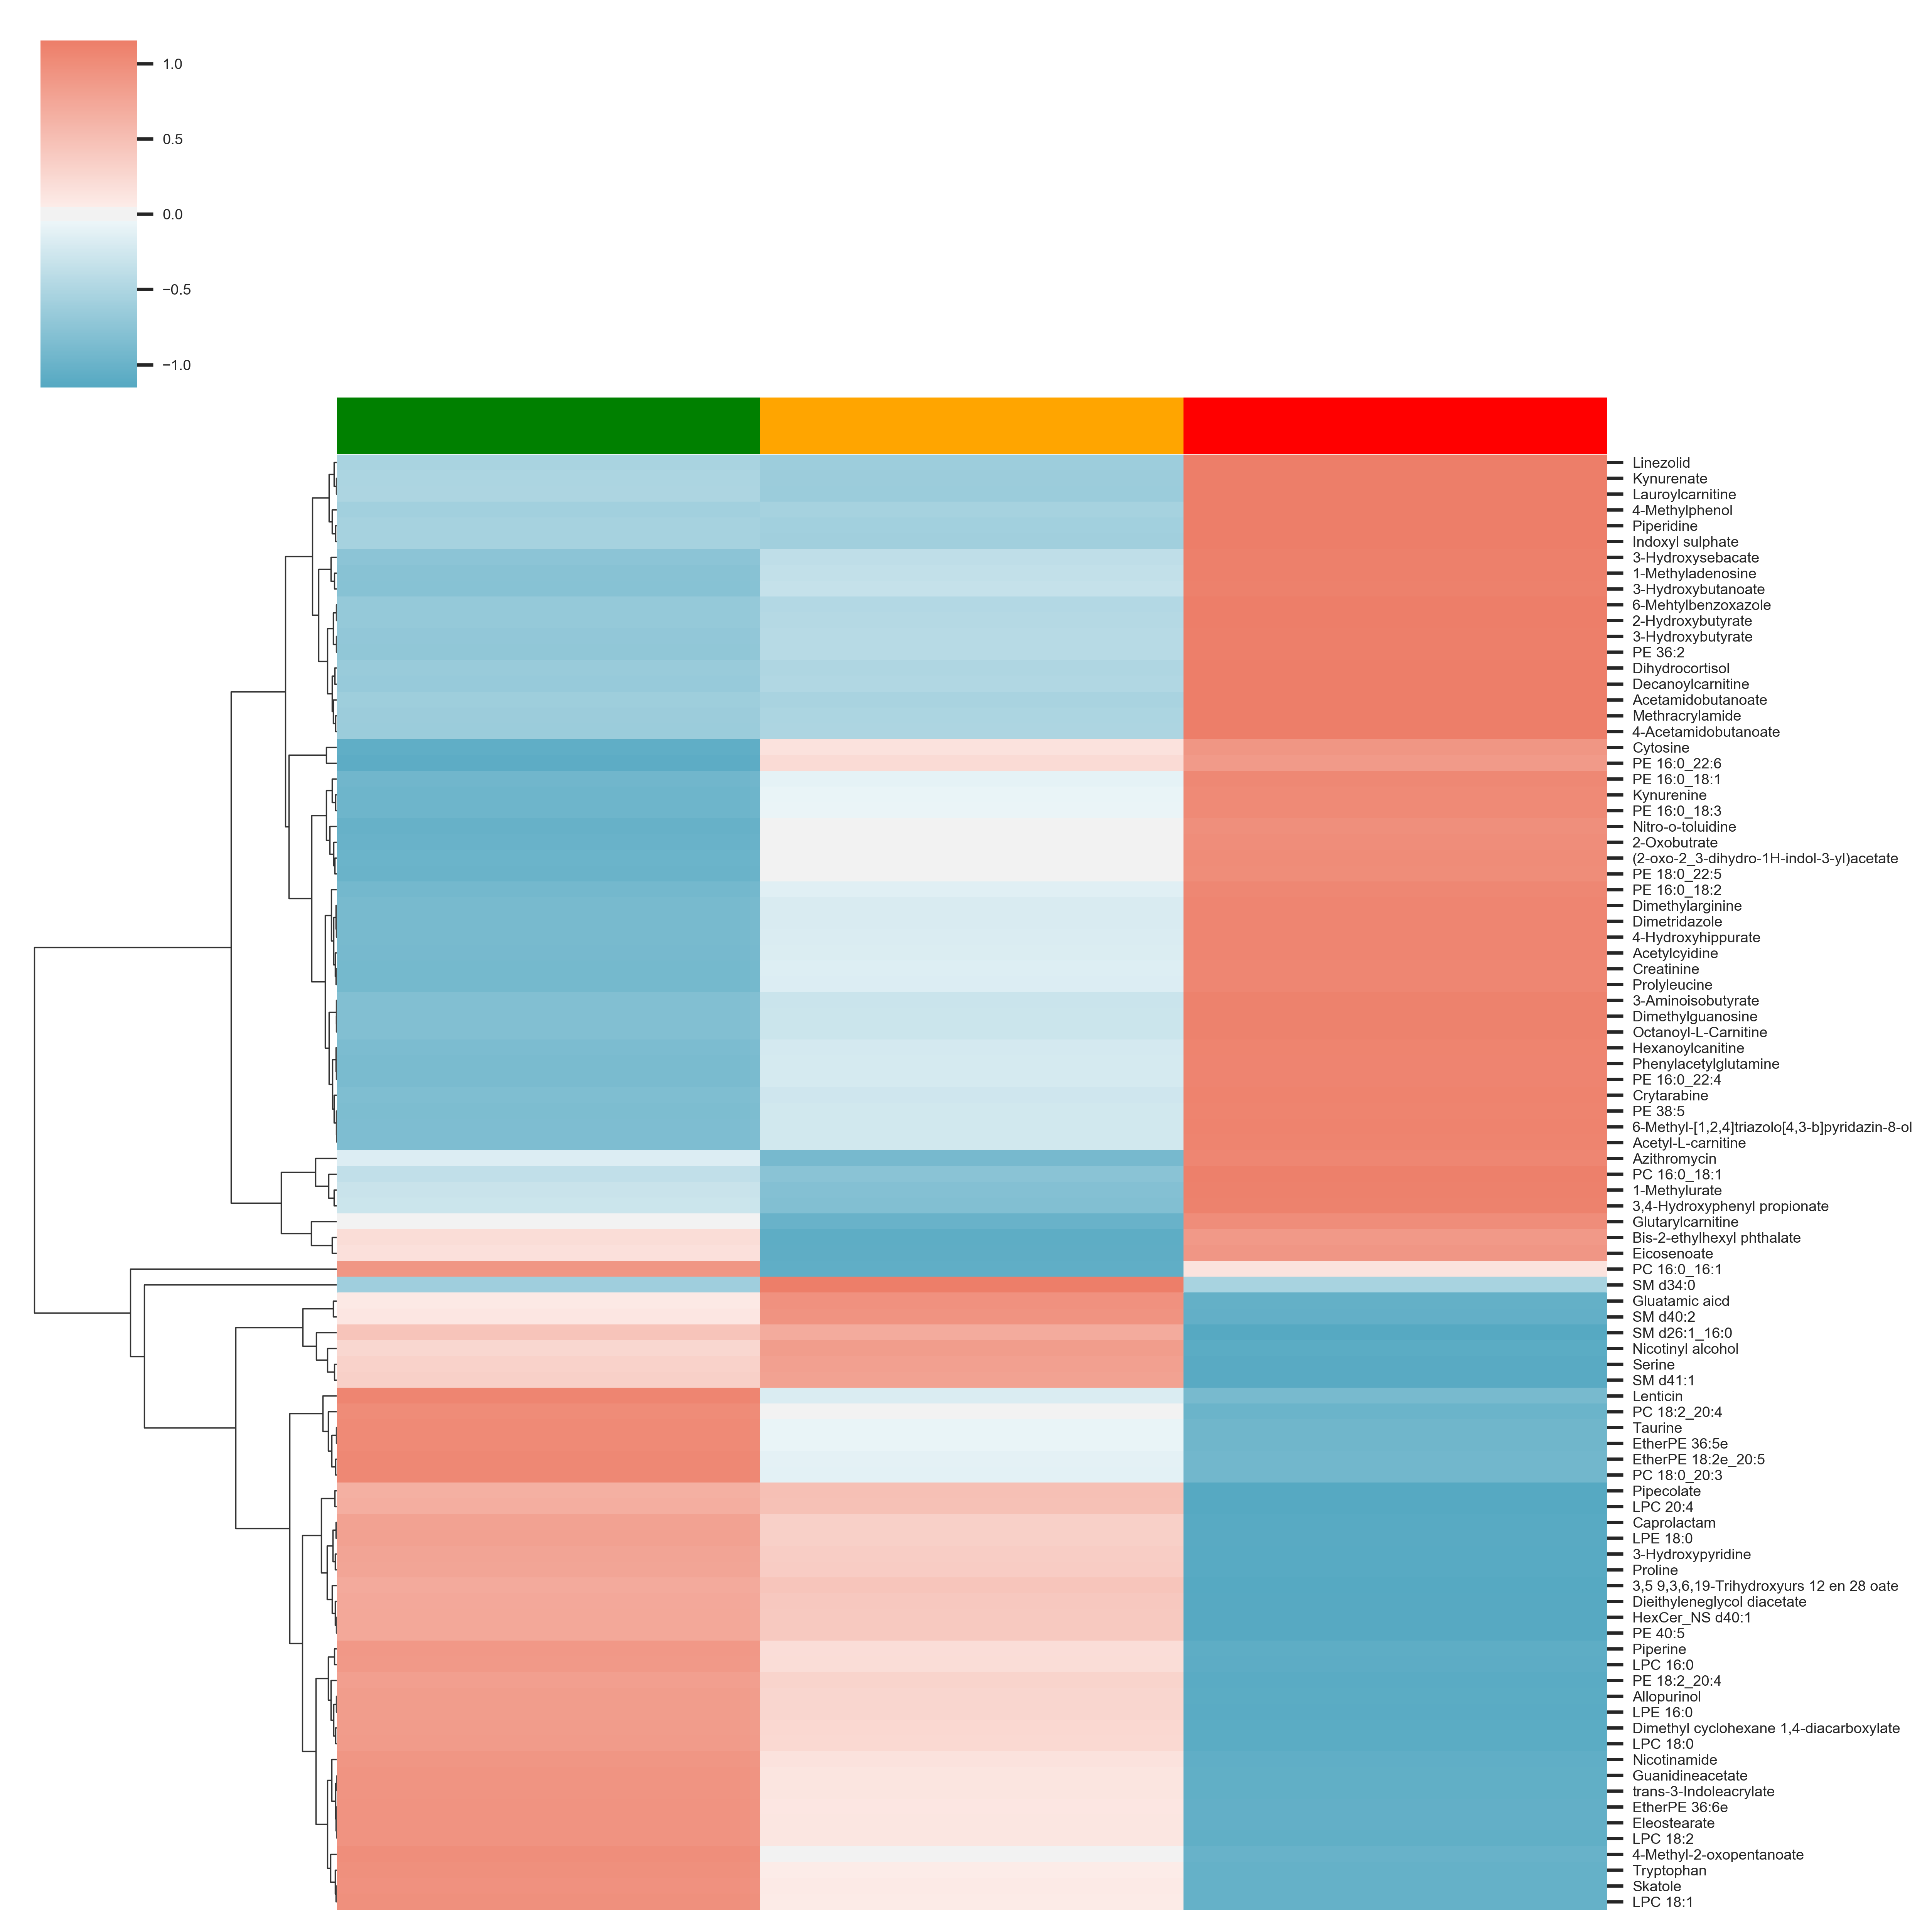

In [3]:
tmp = pd.read_csv("../data/full_model_metabolites_final_updated_6_23.csv",index_col=0)
metsOfInterest = tmp.index.values
metsOfInterest = [[y for y in range(len(mol_names)) if mol_names[y] == x][0] for x in metsOfInterest]

posSevPartion = np.mean(np.array([samp_int[x] for x in range(len(samp_int)) if samp_vent[x] > .5])[:,metsOfInterest],axis=0)
posNSPartion = np.mean(np.array([samp_int[x] for x in range(len(samp_int)) if samp_vent[x] < .5])[:,metsOfInterest],axis=0)
negPartion = np.mean(val_int[:,metsOfInterest],axis=0)



colors =["green","orange","red"]

mat = np.array([negPartion,posNSPartion,posSevPartion]).transpose()
sb.set(font_scale=0.5)


names = [tmp.at[x,"plot-name"] for x in np.array(mol_names)[metsOfInterest]]
p = sb.clustermap(mat,row_cluster=True,col_cluster=False,z_score=0,yticklabels=names,
              xticklabels=False,col_colors=colors,cmap=sb.diverging_palette(220, 20, l=65, center="light", as_cmap=True))
p.savefig("../manuscript_figs/full_model_heatmap.png")

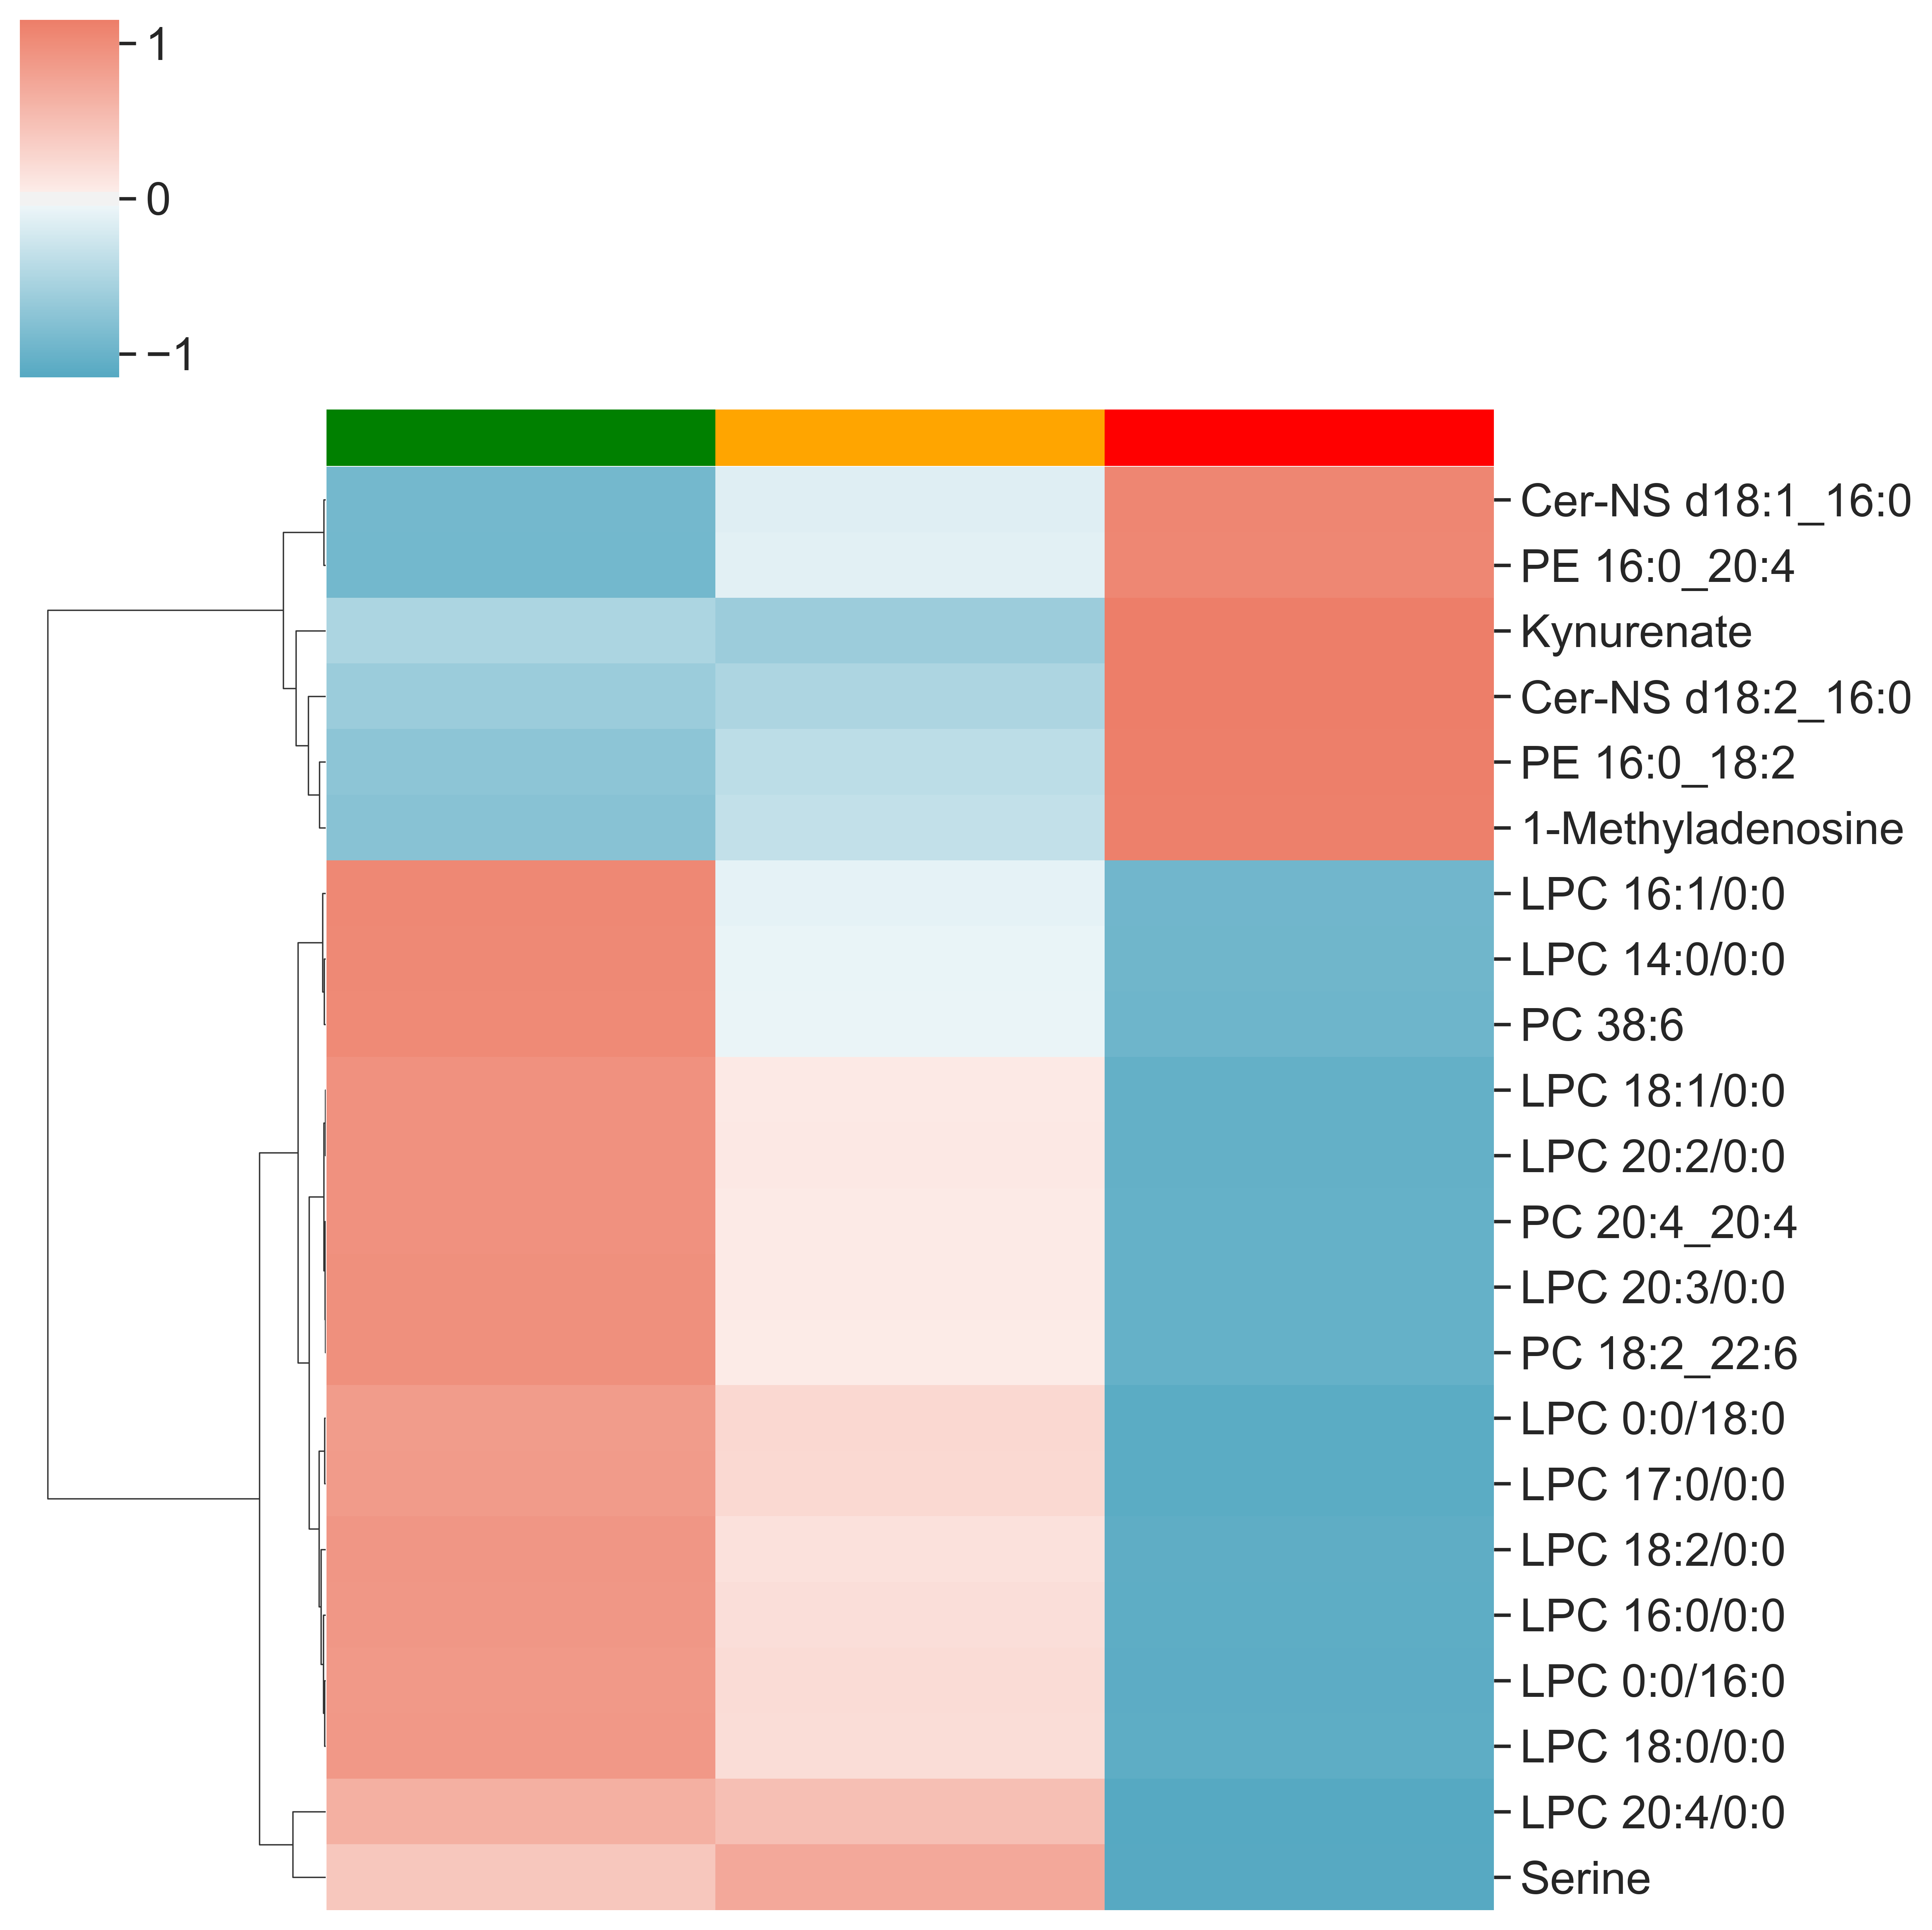

In [4]:
tmp = pd.read_csv("../data/var_importance_final_updated_6_23.csv",index_col=0)
metsOfInterest = tmp.index.values
metsOfInterest = [[y for y in range(len(mol_names)) if mol_names[y] == x][0] for x in metsOfInterest]

posSevPartion = np.mean(np.array([samp_int[x] for x in range(len(samp_int)) if samp_vent[x] > .5])[:,metsOfInterest],axis=0)
posNSPartion = np.mean(np.array([samp_int[x] for x in range(len(samp_int)) if samp_vent[x] < .5])[:,metsOfInterest],axis=0)
negPartion = np.mean(val_int[:,metsOfInterest],axis=0)



colors =["green","orange","red"]

mat = np.array([negPartion,posNSPartion,posSevPartion]).transpose()
sb.set(font_scale=1.5)


names = [tmp.at[x,"plot-name"] for x in np.array(mol_names)[metsOfInterest]]
p = sb.clustermap(mat,row_cluster=True,col_cluster=False,z_score=0,yticklabels=names,
              xticklabels=False,col_colors=colors,cmap=sb.diverging_palette(220, 20, l=65, center="light", as_cmap=True))
p.savefig("../manuscript_figs/reduced_model_heatmap.png")

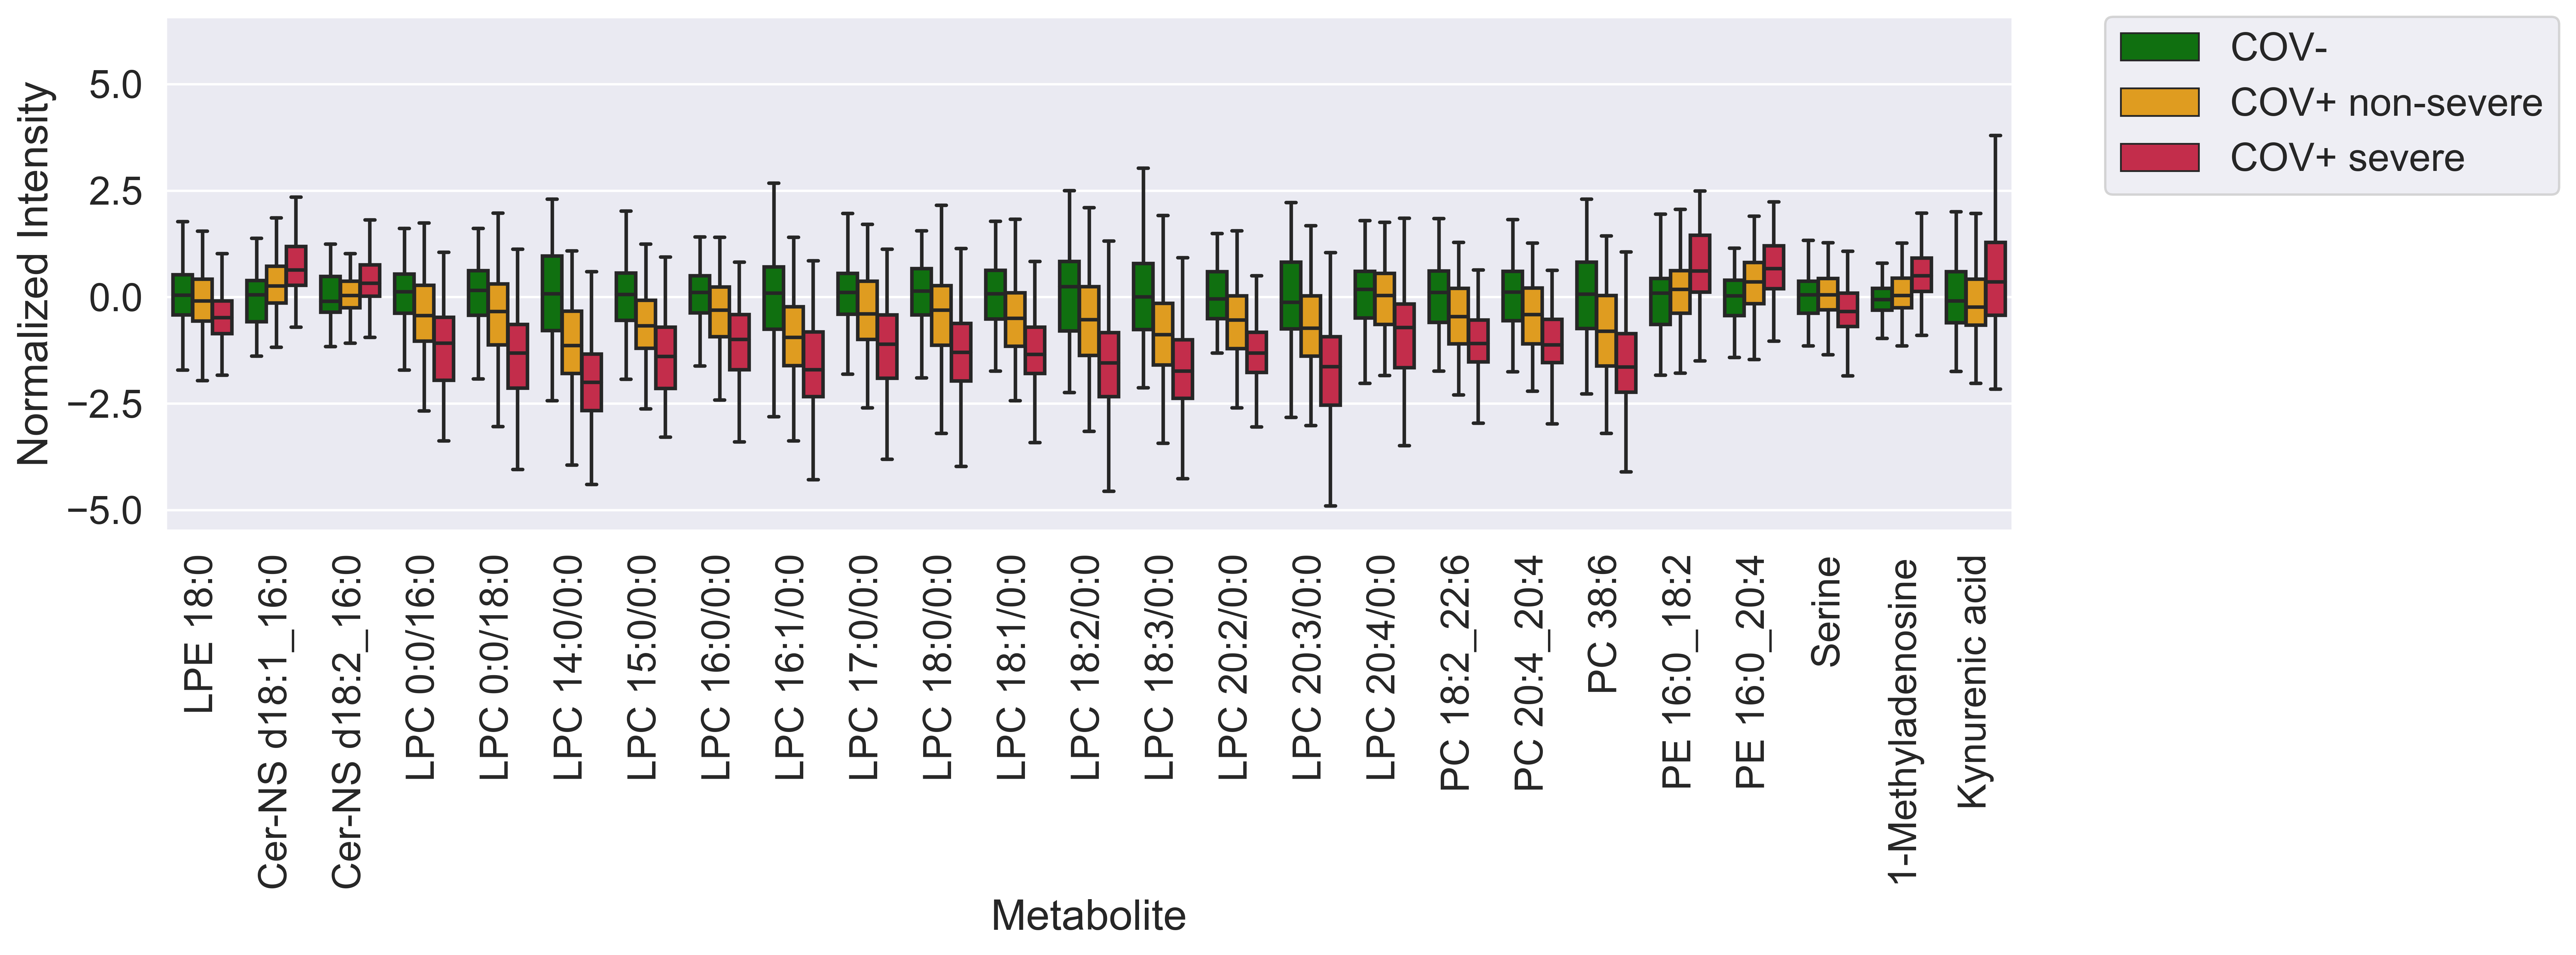

In [5]:

ind = 0

tempDict = {}



mapper = {-1:"COV-",0:"COV+ non-severe",1:"COV+ severe"}
for met,i in zip(names,metsOfInterest):
    norm = np.mean(val_int[:,i])
    tempX = np.concatenate((samp_int[:,i],val_int[:,i])) - norm
    tempy = np.concatenate((samp_vent,[-1 for x in val_int]))
    for x,yy in zip(tempX,tempy):
        tempDict[ind] = {"ICU":mapper[yy],"Normalized Intensity":x,"Metabolite":met}
        ind += 1
    
    
tempDf = pd.DataFrame.from_dict(tempDict,orient="index")

fig,ax = plt.subplots(figsize=(14,4))

# sb.swarmplot(data=tempDf,x="Metabolite",y="Normalized Intensity",hue="ICU",dodge=True,palette={mapper[-1]:"green",
#                                                                                  mapper[0]:"orange",
#                                                                                  mapper[1]:"crimson"},size=1.5)
sb.boxplot(data=tempDf,x="Metabolite",y="Normalized Intensity",hue="ICU",fliersize=0,palette={mapper[-1]:"green",
                                                                                 mapper[0]:"orange",
                                                                                 mapper[1]:"crimson"},
           hue_order=["COV-","COV+ non-severe","COV+ severe"])
plt.xticks(rotation=90)

handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[0:3], labels[0:3], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.tight_layout()
plt.savefig("box_plot_important_mets.png")